#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
feature = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/features.csv')

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [71]:
# shape
print(data.shape)
print('='*100)
print(feature.shape)

(5881, 563)
(561, 4)


In [72]:
# info
print(data.info())
print('='*100)
print(feature.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB
None


In [73]:
# decribe
display(data.describe())
print('='*100)
display(feature.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,533
top,fBodyGyro,bandsEnergy(),X,"fBodyGyro-bandsEnergy()-25,32"
freq,79,126,76,3


In [74]:
display(data.head())
print('='*100)
display(feature.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [75]:
!pip install imbalanced-learn

<< 기초통계량 >>


,count,unique,top,freq
Activity,5881,6,LAYING,1115


<< 그래프 >>
<< 범주별 빈도수 >>
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64
<< 범주별 비율 >>
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64


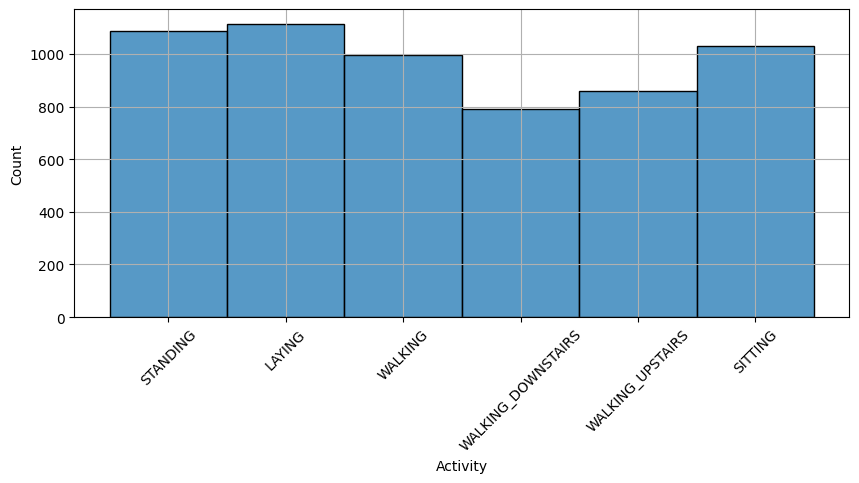

In [76]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'Activity'
eda_1_num(data, target)

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [77]:
# sensor 별 변수의 개수
feature['sensor'].value_counts()

fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: sensor, dtype: int64

In [78]:
# agg(regation) 별 변수의 개수
feature['agg'].value_counts()

bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: agg, dtype: int64

In [79]:
# axis 별 변수의 개수
feature['axis'].value_counts()

X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: axis, Length: 62, dtype: int64

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [80]:
# x, y로 나누기
y = data['Activity']
x = data.drop(columns = 'Activity')

In [81]:
# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

In [82]:
# 랜덤포레스트 이용하여 모델링
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(X_val)
accuracy_score(y_val, y_pred)

0.9762107051826678

In [83]:
plot_feature_importances = model_RF.feature_importances_

In [84]:
indices = np.argsort(plot_feature_importances)[::-1]

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [85]:
Feature_names = X_train.columns

In [86]:
# 상위 10개
top10_importances = []
print("상위 10개 변수:")
for idx in indices[:10]:
    top10_importances.append(Feature_names[idx])
top10_importances

상위 10개 변수:


['tGravityAcc-mean()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-max()-Y',
 'tGravityAcc-min()-X',
 'angle(Y,gravityMean)',
 'tGravityAcc-mean()-Y',
 'angle(X,gravityMean)',
 'tGravityAcc-min()-Y',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Y']

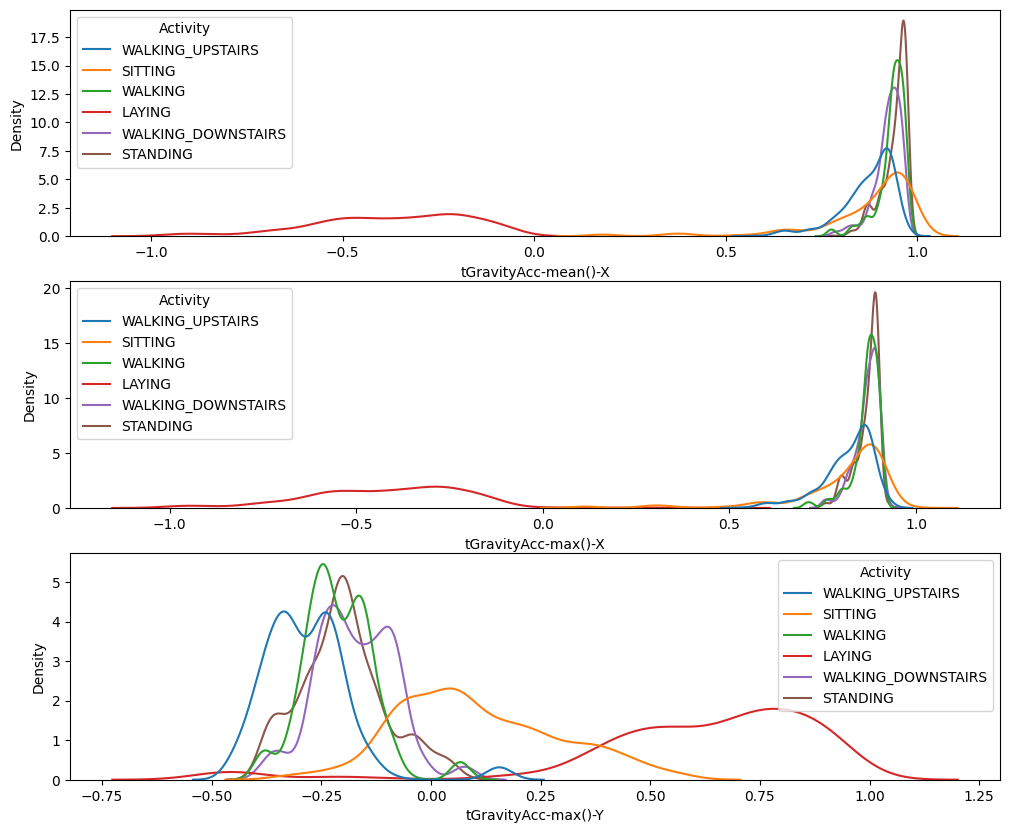

In [87]:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
sns.kdeplot(data=X_train, x=top10_importances[0], hue=y_train, common_norm=False)

plt.subplot(3,1,2)
sns.kdeplot(data=X_train, x=top10_importances[1], hue=y_train, common_norm=False)

plt.subplot(3,1,3)
sns.kdeplot(data=X_train, x=top10_importances[2], hue=y_train, common_norm=False)

plt.show()


In [88]:
# 하위 5개
bttom5_importances = []
print("하위 5개 변수:")
for idx in indices[-10:]:
    bttom5_importances.append(Feature_names[idx])
bttom5_importances

하위 5개 변수:


['fBodyAccJerk-bandsEnergy()-57,64',
 'fBodyAccJerk-bandsEnergy()-33,48.1',
 'tBodyGyroMag-std()',
 'tBodyGyro-arCoeff()-X,2',
 'fBodyBodyGyroJerkMag-entropy()',
 'fBodyAcc-bandsEnergy()-57,64.2',
 'fBodyAcc-entropy()-Y',
 'fBodyAcc-bandsEnergy()-25,48.1',
 'fBodyBodyGyroMag-mad()',
 'tBodyAcc-min()-Z']

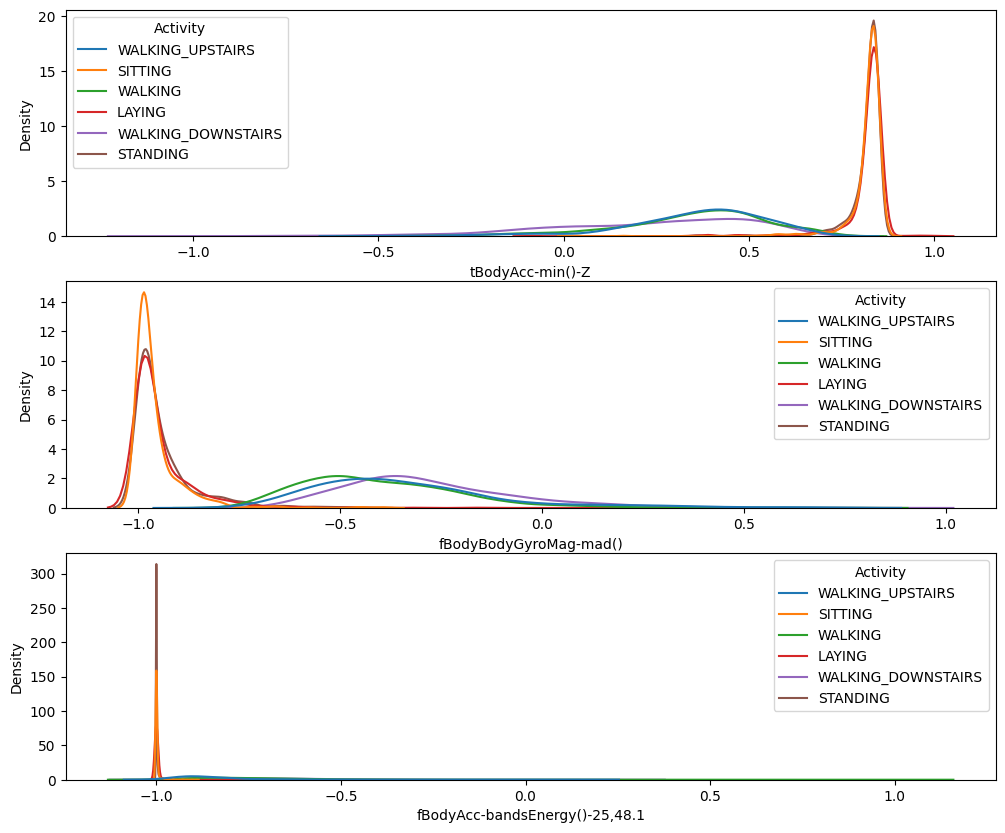

In [89]:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
sns.kdeplot(data=X_train, x=bttom5_importances[-1], hue=y_train, common_norm=False)

plt.subplot(3,1,2)
sns.kdeplot(data=X_train, x=bttom5_importances[-2], hue=y_train, common_norm=False)

plt.subplot(3,1,3)
sns.kdeplot(data=X_train, x=bttom5_importances[-3], hue=y_train, common_norm=False)

plt.show()


In [90]:
# def plot_multiple_kde(data_list, labels, colors):
#     plt.figure(figsize=(8, 6))
#     for data, label, color in zip(data_list, labels, colors):
#         sns.kdeplot(data, label=label, color=color)
#     plt.legend()
#     plt.show()

# data_list = [X_train[i] for i in top10_importances]
# labels = X_train[top10_importances].columns.tolist()
# colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta']

# plot_multiple_kde(data_list, labels, colors)

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


In [91]:
# features와 변수중요도 결과를 merge
tmp = {'feature_name': Feature_names, 'importance_mission1': plot_feature_importances}
feature_importance_df = pd.DataFrame(tmp)

# 위에서 출력한 상위 10개 결과와 동일한지 확인
feature_importance_df.sort_values('importance_mission1',ascending=False).head(10)
# feature_importance_df_misson1 = feature_importance_df.copy()

,feature_name,importance_mission1
40,tGravityAcc-mean()-X,0.039953
49,tGravityAcc-max()-X,0.029467
50,tGravityAcc-max()-Y,0.027726
52,tGravityAcc-min()-X,0.027199
559,"angle(Y,gravityMean)",0.026835
41,tGravityAcc-mean()-Y,0.024958
558,"angle(X,gravityMean)",0.024659
53,tGravityAcc-min()-Y,0.024542
56,tGravityAcc-energy()-X,0.021810
57,tGravityAcc-energy()-Y,0.013045


In [92]:
feature1 = pd.merge(feature, feature_importance_df, on='feature_name')
feature1

,sensor,agg,axis,feature_name,importance_mission1
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835


In [93]:
# sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석
feature1.groupby('sensor').sum('importance_mission1').sort_values('importance_mission1', ascending=False)

,importance_mission1
sensor,
tGravityAcc,0.342681
fBodyAccJerk,0.101399
fBodyGyro,0.083116
fBodyAcc,0.081618
angle,0.062895
tBodyAccJerk,0.059880
fBodyAccMag,0.043906
tBodyGyro,0.039541
tBodyGyroJerk,0.038616


In [94]:
# sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석
feature1.groupby(['sensor', 'agg']).sum('importanimportance_mission1').sort_values('importance_mission1', ascending=False)

importance_mission1
sensor               agg                            
tGravityAcc          mean()                 0.073000
                     arCoeff()              0.071920
                     max()                  0.070127
                     min()                  0.059618
                     energy()               0.042817
...                                              ...
tBodyAccJerkMag      arCoeff()1             0.000126
tGravityAccMag       entropy()              0.000112
tBodyGyroMag         std()                  0.000101
fBodyBodyGyroJerkMag entropy()              0.000100
fBodyBodyGyroMag     mad()                  0.000045

[221 rows x 1 columns]

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [95]:
non_dynamic = ['SITTING', 'STANDING', 'LAYING']
data['is_dynamic'] = data['Activity'].map(lambda x: 0 if x in non_dynamic else 1)
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS,1


#### 2) 기본모델 생성

In [96]:
# x, y로 나누기
y = data['is_dynamic']
x = data.drop(columns = ['is_dynamic', 'Activity'])

# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

# 랜덤포레스트 이용하여 모델링
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(X_val)
accuracy_score(y_val, y_pred)

0.9991503823279524

In [97]:
plot_feature_importances = model_RF.feature_importances_

In [98]:
indices = np.argsort(plot_feature_importances)[::-1]

#### 3) 변수중요도 상위 5개 분석

In [99]:
Feature_names = X_train.columns

In [100]:
# 상위 5개
top5_importances = []
for idx in indices[:5]:
    top5_importances.append(Feature_names[idx])

print("상위 5개 변수:")

상위 5개 변수:


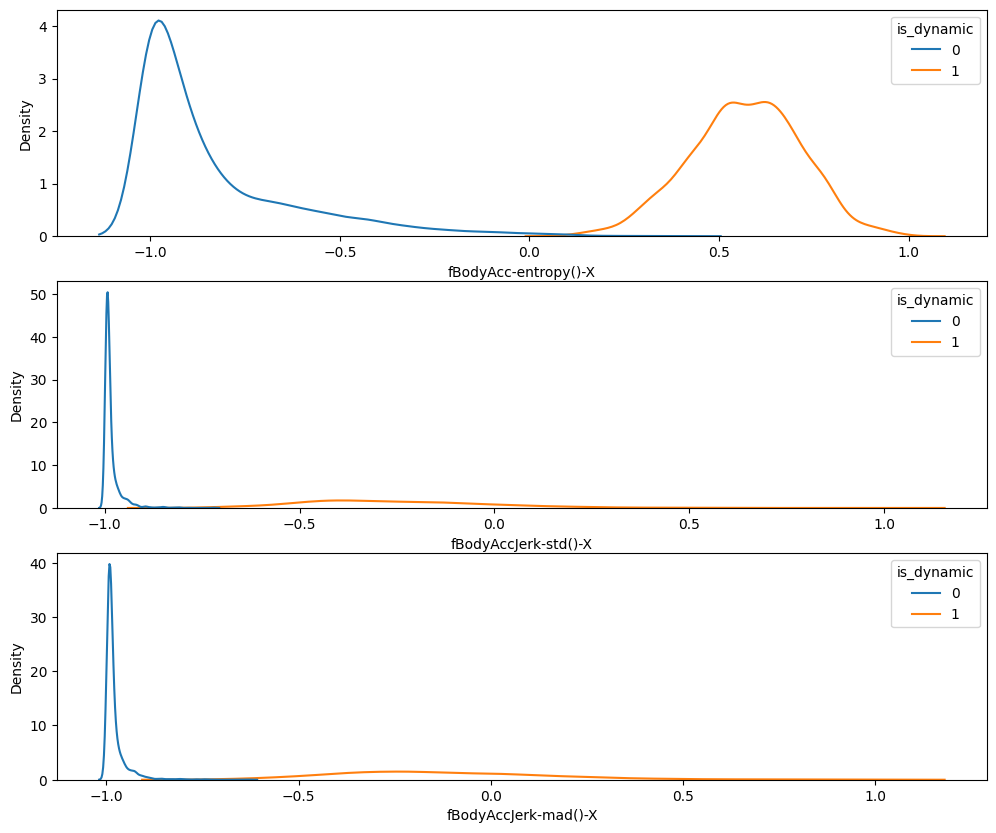

In [101]:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
sns.kdeplot(data=X_train, x=top5_importances[0], hue=y_train, common_norm=False)

plt.subplot(3,1,2)
sns.kdeplot(data=X_train, x=top5_importances[1], hue=y_train, common_norm=False)

plt.subplot(3,1,3)
sns.kdeplot(data=X_train, x=top5_importances[2], hue=y_train, common_norm=False)

plt.show()

In [102]:
# 하위 5개
bttom5_importances = []
print("하위 5개 변수:")
for idx in indices[-5:]:
    bttom5_importances.append(Feature_names[idx])
print(bttom5_importances)

하위 5개 변수:
['fBodyAcc-kurtosis()-Y', 'fBodyAcc-skewness()-Z', 'fBodyAcc-kurtosis()-Z', 'fBodyGyro-bandsEnergy()-33,40.1', 'subject']


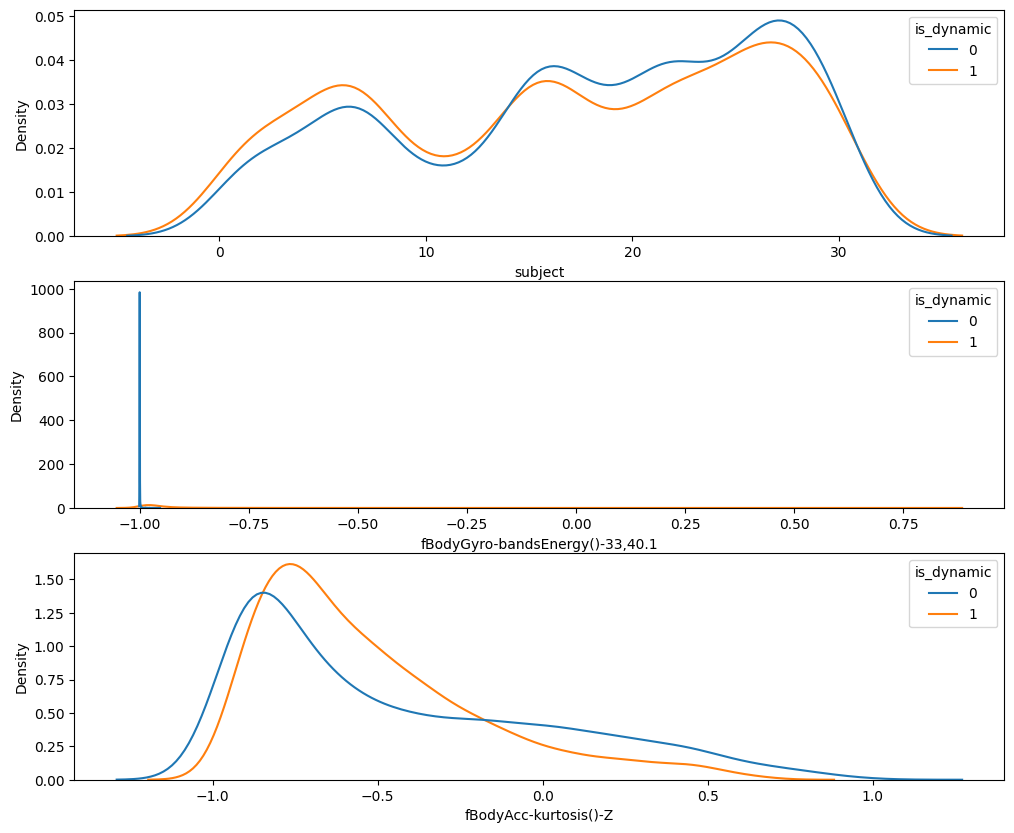

In [103]:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
sns.kdeplot(data=X_train, x=bttom5_importances[-1], hue=y_train, common_norm=False)

plt.subplot(3,1,2)
sns.kdeplot(data=X_train, x=bttom5_importances[-2], hue=y_train, common_norm=False)

plt.subplot(3,1,3)
sns.kdeplot(data=X_train, x=bttom5_importances[-3], hue=y_train, common_norm=False)

plt.show()

In [104]:
# def plot_multiple_kde(data_list, labels, colors):
#     plt.figure(figsize=(6, 4))
#     for data, label, color in zip(data_list, labels, colors):
#         sns.kdeplot(data, label=label, color=color)
#     plt.legend()
#     plt.show()

# data_list = [X_train[i] for i in top5_importances]
# labels = X_train[top5_importances].columns.tolist()
# colors = ['blue', 'green', 'red', 'purple', 'orange']

# plot_multiple_kde(data_list, labels, colors)

#### 4) feature 그룹별 분석

In [105]:
# features와 변수중요도 결과를 merge
tmp = {'feature_name': Feature_names, 'importance_mission2': plot_feature_importances}
feature_importance_df = pd.DataFrame(tmp)
# feature_importance_df = feature_importance_df[:-1]

# 위에서 출력한 상위 5개 결과와 동일한지 확인
feature_importance_df.sort_values('importance_mission2',ascending=False).head(10)
# feature_importance_df_mission2 = feature_importance_df.copy()

,feature_name,importance_mission2
287,fBodyAcc-entropy()-X,0.059735
347,fBodyAccJerk-std()-X,0.049982
350,fBodyAccJerk-mad()-X,0.049854
344,fBodyAccJerk-mean()-X,0.040051
181,tBodyGyroJerk-iqr()-Z,0.040044
353,fBodyAccJerk-max()-X,0.040011
102,tBodyAccJerk-entropy()-X,0.039974
95,tBodyAccJerk-sma(),0.030017
381,"fBodyAccJerk-bandsEnergy()-1,8",0.030000
86,tBodyAccJerk-mad()-X,0.029983


In [106]:
feature1 = pd.merge(feature1, feature_importance_df, on='feature_name')
feature1

,sensor,agg,axis,feature_name,importance_mission1,importance_mission2
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213,0.000009
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289,0.000017
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183,0.000034
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241,0.000009
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351,0.000000
...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549,0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753,0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659,0.000111
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835,0.000000


In [107]:
# sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석
feature1.groupby('sensor').sum('importance_mission2').sort_values('importance_mission2', ascending=False)

,importance_mission1,importance_mission2
sensor,,
fBodyAccJerk,0.101399,0.349652
tBodyAccJerk,0.059880,0.219579
fBodyAcc,0.081618,0.139411
tBodyAccJerkMag,0.029645,0.080094
tBodyGyroJerk,0.038616,0.070026
fBodyBodyAccJerkMag,0.021243,0.049484
tBodyGyroJerkMag,0.009512,0.039752
tBodyGyro,0.039541,0.020417
fBodyGyro,0.083116,0.019940


In [108]:
# sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석
feature1.groupby(['sensor', 'agg']).sum('importance_mission2').sort_values('importance_mission2', ascending=False)

importance_mission1  importance_mission2
sensor           agg                                                    
fBodyAccJerk     bandsEnergy()             0.040524             0.110005
tBodyAccJerk     entropy()                 0.009738             0.059828
fBodyAccJerk     mad()                     0.006978             0.059768
tBodyAccJerk     mad()                     0.009547             0.059754
fBodyAcc         entropy()                 0.006597             0.059735
...                                             ...                  ...
fBodyBodyGyroMag sma()                     0.000251             0.000000
                 std()                     0.000144             0.000000
fBodyGyro        bandsEnergy()             0.038849             0.000000
                 energy()                  0.001679             0.000000
tGravityAccMag   std()                     0.007326             0.000000

[221 rows x 2 columns]

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [109]:
# 함수로 만드렀당ㅇ

def analyze_feature_importance(data, target_column, exclude_columns, feature1, top_n=3, bottom_n=3):
    # x, y로 나누기
    y = data[target_column]
    x = data.drop(columns=exclude_columns)

    # train과 validation 분할 수행
    X_train, X_val, y_train, y_val = train_test_split(x, y, stratify=y, random_state=42, test_size=0.2)

    # 랜덤포레스트 이용하여 모델링
    model_RF = RandomForestClassifier(random_state=42)
    model_RF.fit(X_train, y_train)

    # 성능 평가
    y_pred = model_RF.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # 변수 중요도 계산
    plot_feature_importances = model_RF.feature_importances_
    indices = np.argsort(plot_feature_importances)[::-1]
    Feature_names = X_train.columns

    # 상위 n개 변수와 하위 n개 변수 선택
    top_importances = []
    bottom_importances = []
    for idx in indices[:top_n]:
        top_importances.append(Feature_names[idx])
    for idx in indices[-bottom_n:]:
        bottom_importances.append(Feature_names[idx])

    # 상위 n개 변수 시각화
    plt.figure(figsize=(12, 10))
    for i, feat in enumerate(top_importances):
        plt.subplot(top_n, 1, i + 1)
        sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)

    plt.show()

    print('='*200)

    # 하위 n개 변수 시각화
    plt.figure(figsize=(12, 10))
    for i, feat in enumerate(bottom_importances):
        plt.subplot(bottom_n, 1, i + 1)
        sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)

    plt.show()

    print('='*200)

    # features와 변수중요도 결과를 merge
    tmp = {'feature_name': Feature_names, f'importportance_{target_column}': plot_feature_importances}
    feature_importance_df = pd.DataFrame(tmp)

    # feature와 변수 중요도 결과를 merge
    feature_merged = pd.merge(feature1, feature_importance_df, on='feature_name')

    # sensor 별 중요도 합계 및 상위 변수 그룹별 비교 분석
    sensor_importance_summary = feature_merged.groupby('sensor').sum(f'importportance_{target_column}').sort_values(f'importportance_{target_column}', ascending=False)

    # sensor + agg 별 중요도 합계 및 상위 변수 그룹별 비교 분석
    sensor_agg_importance_summary = feature_merged.groupby(['sensor', 'agg']).sum(f'importportance_{target_column}').sort_values(f'importportance_{target_column}', ascending=False)

    return accuracy, top_importances, bottom_importances, sensor_importance_summary, sensor_agg_importance_summary, feature_merged

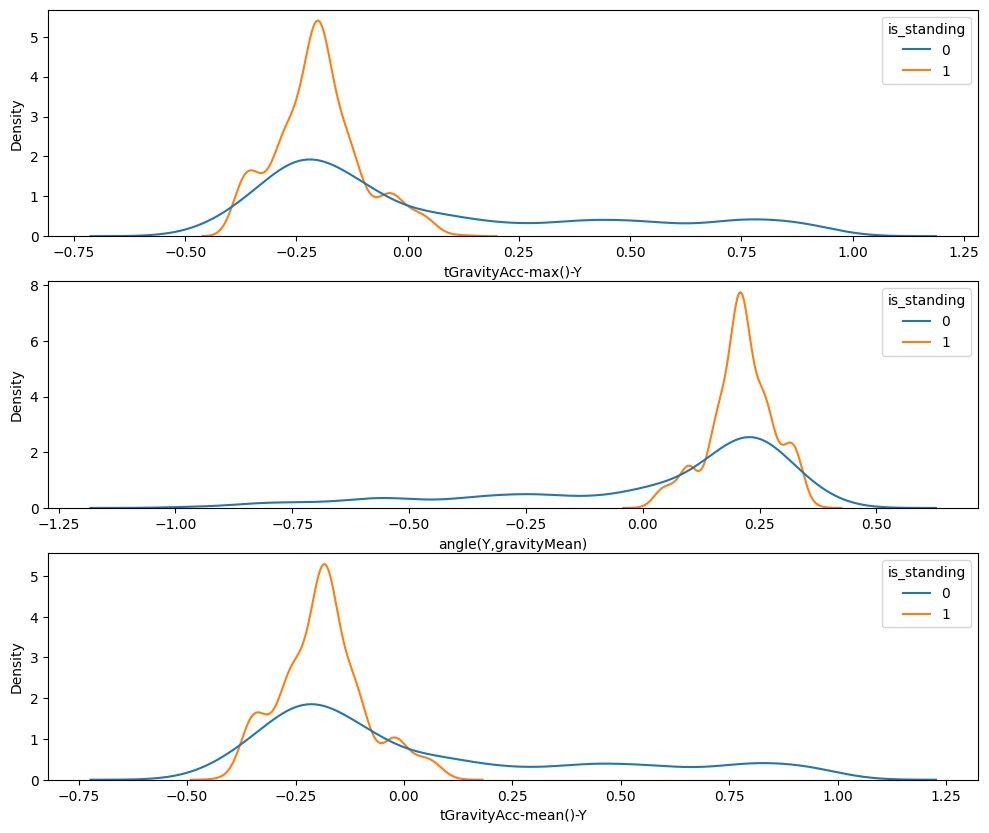

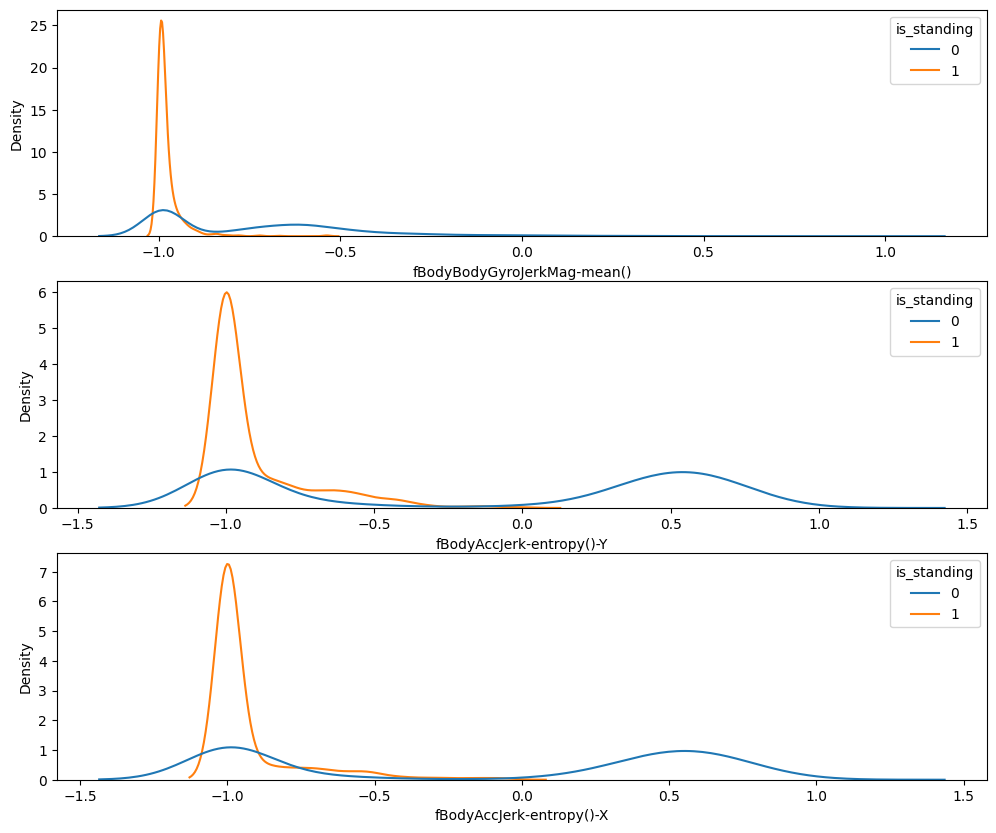

KeyError: ignored

In [111]:
data['is_standing'] = data['Activity'].map(lambda x: 1 if x == 'STANDING' else 0)

# 함수 사용 예제
result = analyze_feature_importance(data, 'is_standing', ['is_dynamic', 'Activity', 'is_standing'], feature1)
print("Accuracy:", result[0])
print('='*200)
print("Top 3 Importances:", result[1])
print('='*200)
print("Bottom 3 Importances:", result[2])
print('='*200)
display("Sensor Importance Summary:", result[3])
print('='*200)
display("Sensor + Agg Importance Summary:", result[4])
print('='*200)
display(result[5])

feature1 = result[5]

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


<ipython-input-109-192857254c47>:36: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)


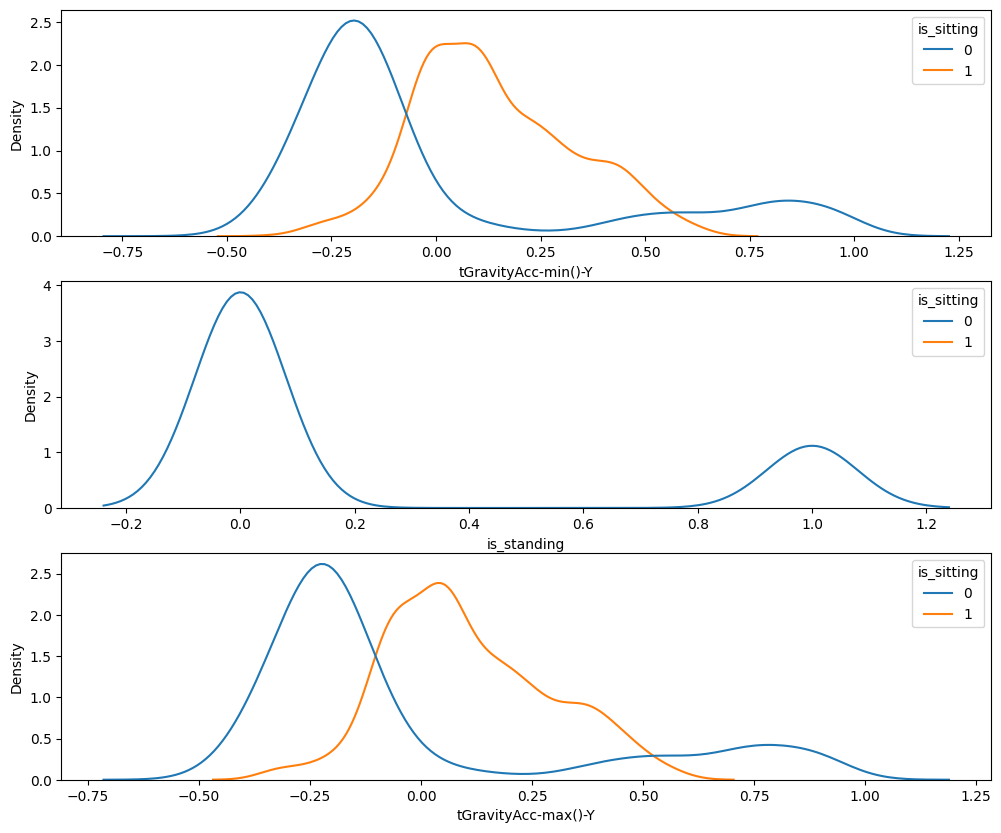

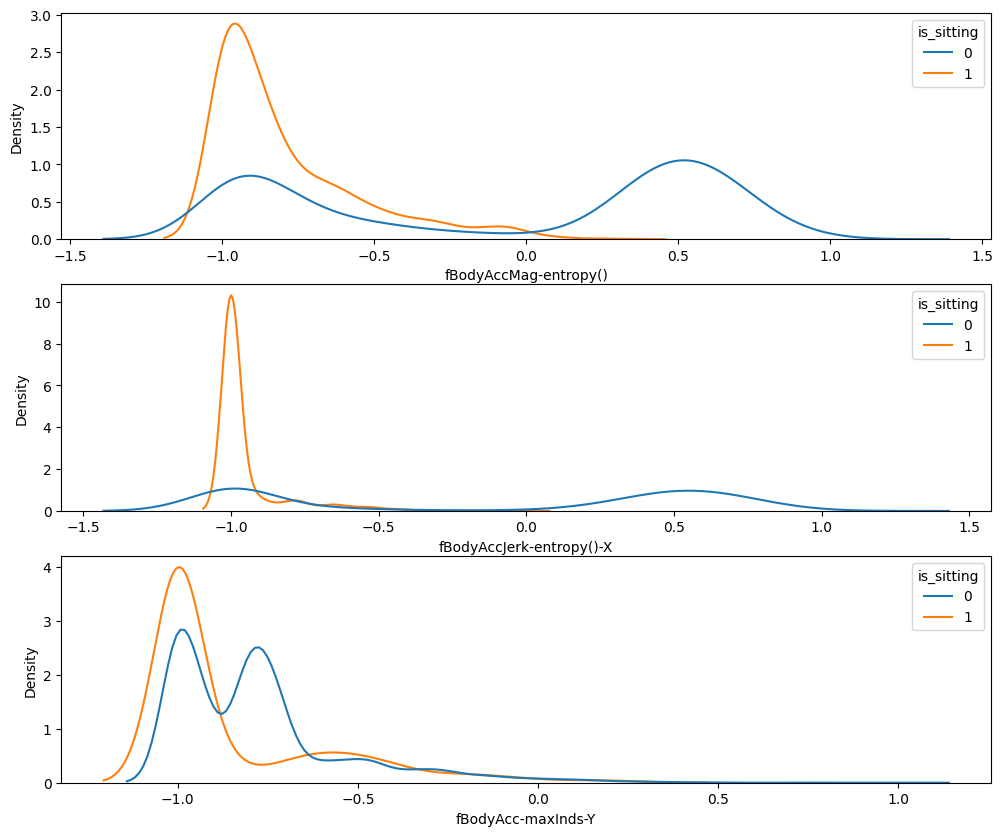

Accuracy: 0.9957519116397621
Top 3 Importances: ['tGravityAcc-min()-Y', 'is_standing', 'tGravityAcc-max()-Y']
Bottom 3 Importances: ['fBodyAccMag-entropy()', 'fBodyAccJerk-entropy()-X', 'fBodyAcc-maxInds-Y']


'Sensor Importance Summary:'

,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting
sensor,,,,
tGravityAcc,0.342681,0.000815,0.388536,0.351293
fBodyGyro,0.083116,0.019940,0.116872,0.258101
tBodyGyro,0.039541,0.020417,0.063805,0.082390
angle,0.062895,0.000188,0.100872,0.073675
tBodyGyroJerk,0.038616,0.070026,0.035208,0.057659
fBodyAcc,0.081618,0.139411,0.105029,0.053076
fBodyAccJerk,0.101399,0.349652,0.033930,0.042625
tBodyAcc,0.036624,0.000557,0.062268,0.039709
tBodyAccJerk,0.059880,0.219579,0.017949,0.024935


'Sensor + Agg Importance Summary:'

importance_mission1  importance_mission2  \
sensor               agg                                                       
fBodyGyro            bandsEnergy()             0.038849             0.000000   
tGravityAcc          mean()                    0.073000             0.000017   
                     min()                     0.059618             0.000137   
                     max()                     0.070127             0.000197   
                     energy()                  0.042817             0.000094   
...                                                 ...                  ...   
fBodyBodyGyroJerkMag maxInds                   0.000148             0.000000   
fBodyBodyAccJerkMag  maxInds                   0.000270             0.000004   
tBodyAccMag          arCoeff()1                0.004379             0.000000   
tBodyAcc             sma()                     0.000305             0.000000   
fBodyAccMag          entropy()                 0.001201             0.009897   

                                    importportance_is_standing  \
sensor               agg                                         
fBodyGyro            bandsEnergy()                    0.066522   
tGravityAcc          mean()                           0.098057   
                     min()                            0.101824   
                     max()                            0.088115   
                     energy()                         0.050713   
...                                                        ...   
fBodyBodyGyroJerkMag maxInds                          0.000242   
fBodyBodyAccJerkMag  maxInds                          0.000217   
tBodyAccMag          arCoeff()1                       0.000104   
tBodyAcc             sma()                            0.002428   
fBodyAccMag          entropy()                        0.000120   

                                    importportance_is_sitting  
sensor               agg                                       
fBodyGyro            bandsEnergy()                   0.167218  
tGravityAcc          mean()                          0.094718  
                     min()                           0.087645  
                     max()                           0.082035  
                     energy()                        0.050585  
...                                                       ...  
fBodyBodyGyroJerkMag maxInds                         0.000075  
fBodyBodyAccJerkMag  maxInds                         0.000073  
tBodyAccMag          arCoeff()1                      0.000070  
tBodyAcc             sma()                           0.000035  
fBodyAccMag          entropy()                       0.000020  

[221 rows x 4 columns]

,sensor,agg,axis,feature_name,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213,0.000009,0.000316,0.000458
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289,0.000017,0.000473,0.000721
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183,0.000034,0.000171,0.000117
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241,0.000009,0.003143,0.003125
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351,0.000000,0.003915,0.000379
...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549,0.000000,0.001799,0.000501
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753,0.000000,0.001643,0.001056
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659,0.000111,0.031404,0.024268
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835,0.000000,0.041812,0.031485


In [112]:
data['is_sitting'] = data['Activity'].map(lambda x: 1 if x == 'SITTING' else 0)

# 함수 사용 예제
result = analyze_feature_importance(data, 'is_sitting', ['is_dynamic', 'Activity', 'is_sitting'], feature1)
print("Accuracy:", result[0])
print('='*200)
print("Top 3 Importances:", result[1])
print('='*200)
print("Bottom 3 Importances:", result[2])
print('='*200)
display("Sensor Importance Summary:", result[3])
print('='*200)
display("Sensor + Agg Importance Summary:", result[4])
print('='*200)
display(result[5])

feature1 = result[5]

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


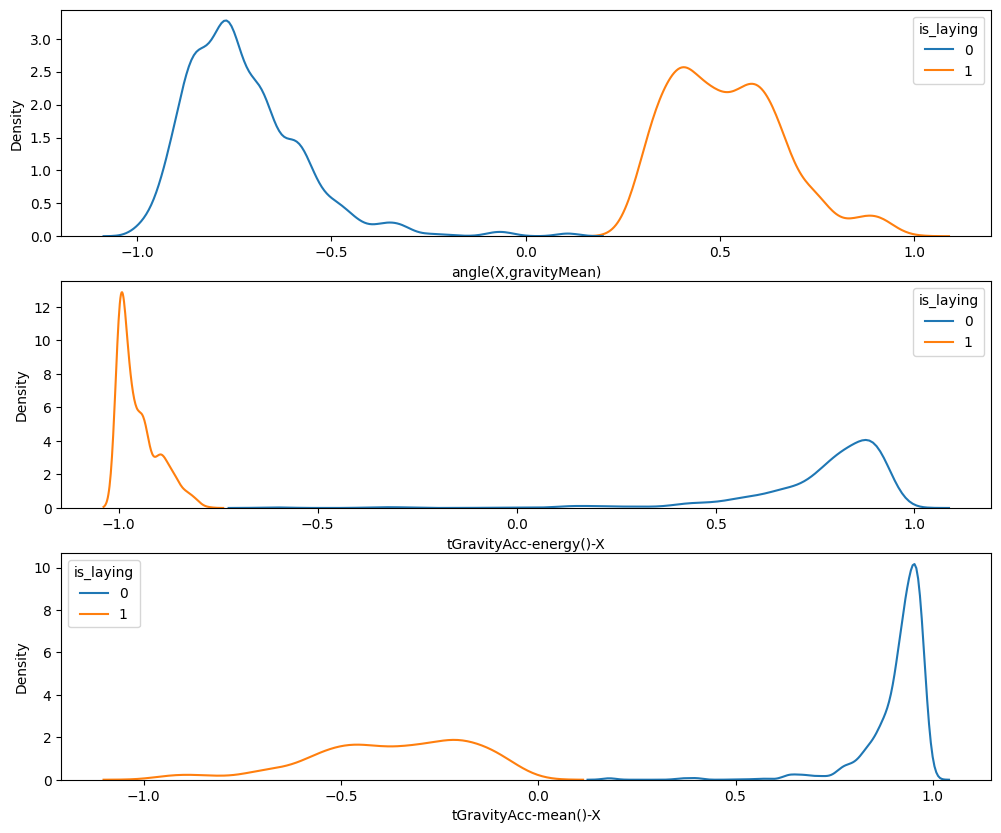

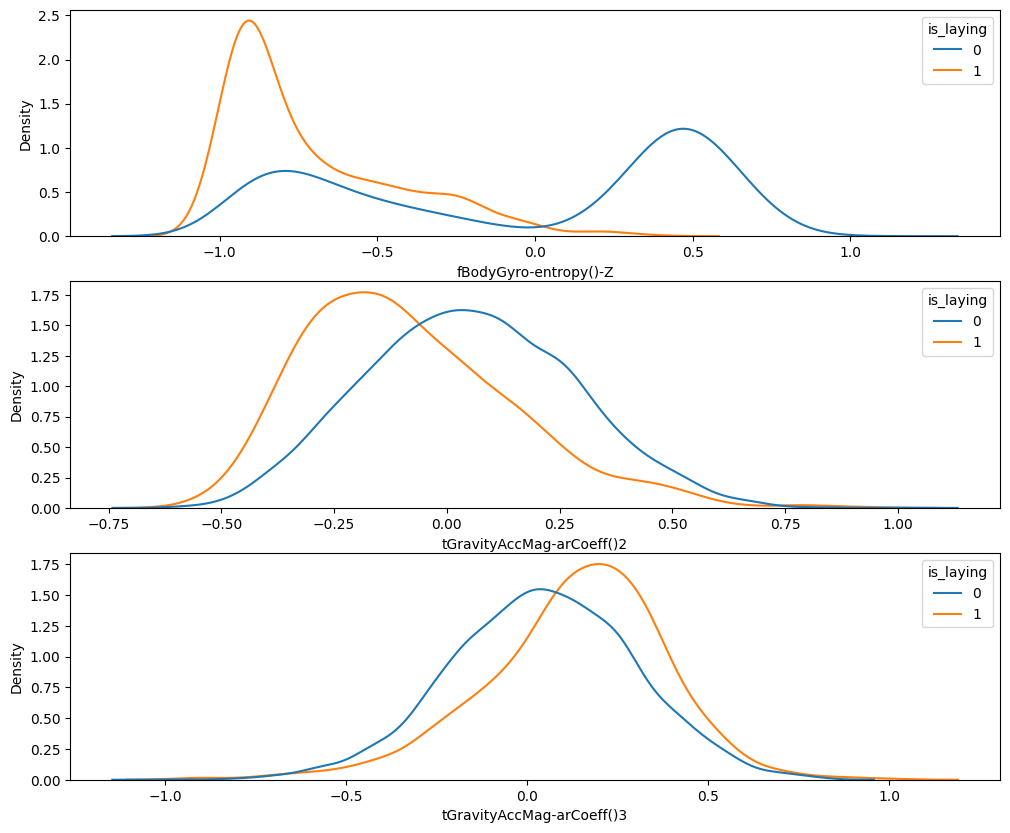

Accuracy: 1.0
Top 3 Importances: ['angle(X,gravityMean)', 'tGravityAcc-energy()-X', 'tGravityAcc-mean()-X']
Bottom 3 Importances: ['fBodyGyro-entropy()-Z', 'tGravityAccMag-arCoeff()2', 'tGravityAccMag-arCoeff()3']


'Sensor Importance Summary:'

,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying
sensor,,,,,
tGravityAcc,0.342681,0.000815,0.388536,0.351293,0.667924
angle,0.062895,0.000188,0.100872,0.073675,0.171567
fBodyAccJerk,0.101399,0.349652,0.033930,0.042625,0.039014
tBodyGyro,0.039541,0.020417,0.063805,0.082390,0.025902
fBodyAcc,0.081618,0.139411,0.105029,0.053076,0.019993
fBodyGyro,0.083116,0.019940,0.116872,0.258101,0.015870
tBodyAcc,0.036624,0.000557,0.062268,0.039709,0.013092
tBodyGyroJerk,0.038616,0.070026,0.035208,0.057659,0.012206
tBodyGyroJerkMag,0.009512,0.039752,0.004599,0.014822,0.004425


'Sensor + Agg Importance Summary:'

importance_mission1  importance_mission2  \
sensor          agg                                                    
tGravityAcc     mean()                 0.073000             0.000017   
                energy()               0.042817             0.000094   
                max()                  0.070127             0.000197   
                min()                  0.059618             0.000137   
angle           X                      0.024659             0.000111   
...                                         ...                  ...   
tBodyAccJerkMag entropy()              0.000377             0.000145   
                energy()               0.010294             0.029932   
                arCoeff()2             0.000303             0.000000   
fBodyGyro       maxInds                0.011624             0.000000   
tGravityAccMag  std()                  0.007326             0.000000   

                            importportance_is_standing  \
sensor          agg                                      
tGravityAcc     mean()                        0.098057   
                energy()                      0.050713   
                max()                         0.088115   
                min()                         0.101824   
angle           X                             0.031404   
...                                                ...   
tBodyAccJerkMag entropy()                     0.000210   
                energy()                      0.000458   
                arCoeff()2                    0.000617   
fBodyGyro       maxInds                       0.000478   
tGravityAccMag  std()                         0.006273   

                            importportance_is_sitting  \
sensor          agg                                     
tGravityAcc     mean()                       0.094718   
                energy()                     0.050585   
                max()                        0.082035   
                min()                        0.087645   
angle           X                            0.024268   
...                                               ...   
tBodyAccJerkMag entropy()                    0.001907   
                energy()                     0.000484   
                arCoeff()2                   0.000263   
fBodyGyro       maxInds                      0.001053   
tGravityAccMag  std()                        0.000264   

                            importportance_is_laying  
sensor          agg                                   
tGravityAcc     mean()                      0.187575  
                energy()                    0.154694  
                max()                       0.146403  
                min()                       0.135276  
angle           X                           0.126069  
...                                              ...  
tBodyAccJerkMag entropy()                   0.000000  
                energy()                    0.000000  
                arCoeff()2                  0.000000  
fBodyGyro       maxInds                     0.000000  
tGravityAccMag  std()                       0.000000  

[221 rows x 5 columns]

,sensor,agg,axis,feature_name,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213,0.000009,0.000316,0.000458,0.000143
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289,0.000017,0.000473,0.000721,0.000069
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183,0.000034,0.000171,0.000117,0.000034
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241,0.000009,0.003143,0.003125,0.002322
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351,0.000000,0.003915,0.000379,0.000711
...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549,0.000000,0.001799,0.000501,0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753,0.000000,0.001643,0.001056,0.000015
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659,0.000111,0.031404,0.024268,0.126069
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835,0.000000,0.041812,0.031485,0.025626


In [113]:
data['is_laying'] = data['Activity'].map(lambda x: 1 if x == 'LAYING' else 0)

# 함수 사용 예제
result = analyze_feature_importance(data, 'is_laying', ['is_dynamic', 'Activity', 'is_laying'], feature1)
print("Accuracy:", result[0])
print('='*200)
print("Top 3 Importances:", result[1])
print('='*200)
print("Bottom 3 Importances:", result[2])
print('='*200)
display("Sensor Importance Summary:", result[3])
print('='*200)
display("Sensor + Agg Importance Summary:", result[4])
print('='*200)
display(result[5])

feature1 = result[5]

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


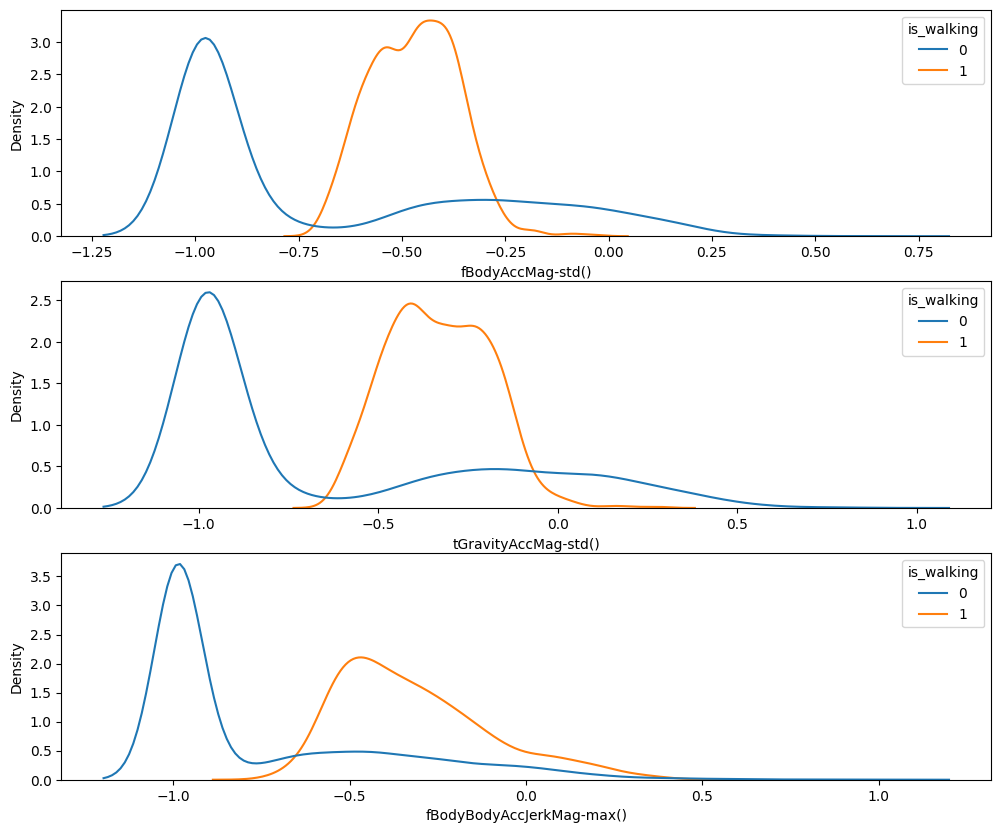

<ipython-input-109-192857254c47>:46: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)
<ipython-input-109-192857254c47>:46: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)


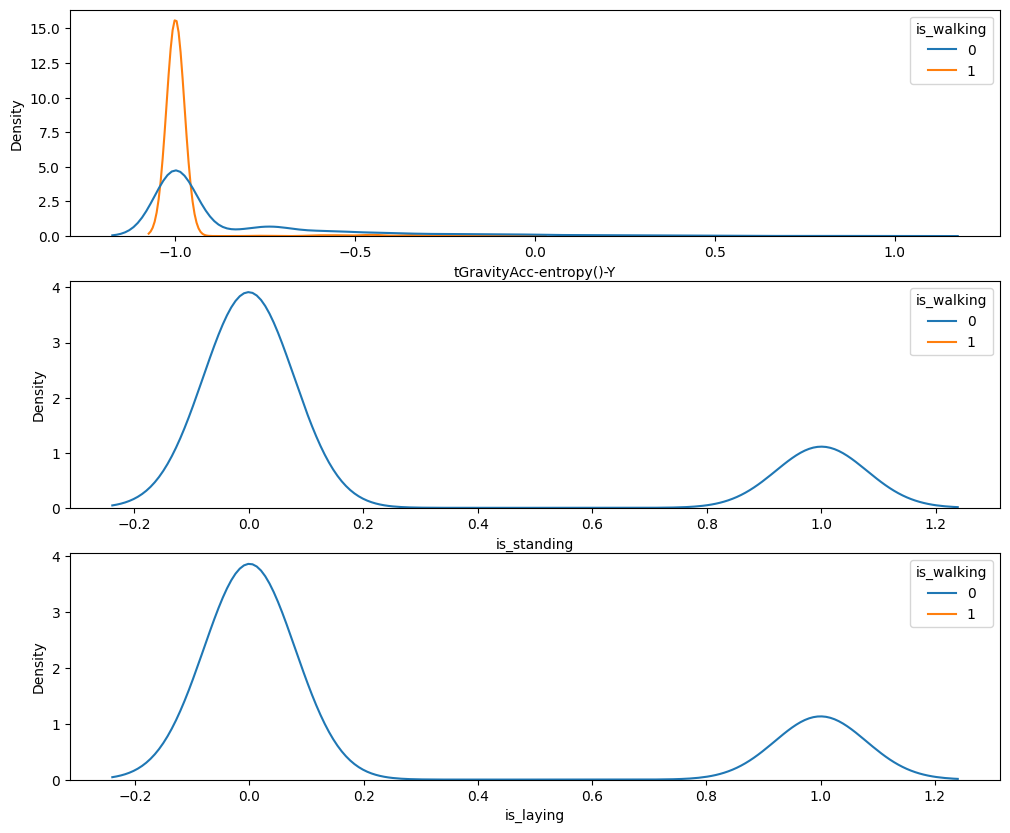

Accuracy: 0.9957519116397621
Top 3 Importances: ['fBodyAccMag-std()', 'tGravityAccMag-std()', 'fBodyBodyAccJerkMag-max()']
Bottom 3 Importances: ['tGravityAcc-entropy()-Y', 'is_standing', 'is_laying']


'Sensor Importance Summary:'

,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking
sensor,,,,,,
tGravityAcc,0.342681,0.000815,0.388536,0.351293,0.667924,0.148585
fBodyAcc,0.081618,0.139411,0.105029,0.053076,0.019993,0.125326
fBodyAccJerk,0.101399,0.349652,0.033930,0.042625,0.039014,0.116843
fBodyGyro,0.083116,0.019940,0.116872,0.258101,0.015870,0.108080
tBodyGyroJerk,0.038616,0.070026,0.035208,0.057659,0.012206,0.096161
fBodyAccMag,0.043906,0.009906,0.026095,0.003776,0.000302,0.085798
tBodyAccMag,0.027031,0.000000,0.019901,0.003329,0.000609,0.084271
tBodyAccJerk,0.059880,0.219579,0.017949,0.024935,0.003515,0.072689
tGravityAccMag,0.022778,0.000000,0.028756,0.003132,0.001308,0.062501


'Sensor + Agg Importance Summary:'

,,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking
sensor,agg,,,,,,
tGravityAcc,arCoeff(),0.071920,0.000017,0.010035,0.006706,0.009111,0.097609
fBodyGyro,bandsEnergy(),0.038849,0.000000,0.066522,0.167218,0.004461,0.079635
fBodyAccJerk,bandsEnergy(),0.040524,0.110005,0.018662,0.029296,0.016233,0.062275
fBodyAcc,bandsEnergy(),0.034072,0.029912,0.038339,0.029683,0.007704,0.061120
fBodyAccMag,std(),0.003738,0.000000,0.002027,0.000174,0.000000,0.030128
...,...,...,...,...,...,...,...
fBodyBodyGyroMag,iqr(),0.000161,0.000000,0.000121,0.000583,0.000060,0.000053
angle,tBodyAccJerkMean,0.000180,0.000000,0.000184,0.000473,0.000061,0.000043
fBodyBodyGyroMag,entropy(),0.000142,0.000007,0.000173,0.000183,0.001911,0.000034


,sensor,agg,axis,feature_name,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213,0.000009,0.000316,0.000458,0.000143,0.000272
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289,0.000017,0.000473,0.000721,0.000069,0.000203
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183,0.000034,0.000171,0.000117,0.000034,0.000029
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241,0.000009,0.003143,0.003125,0.002322,0.009746
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351,0.000000,0.003915,0.000379,0.000711,0.000397
...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549,0.000000,0.001799,0.000501,0.000000,0.000183
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753,0.000000,0.001643,0.001056,0.000015,0.000058
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659,0.000111,0.031404,0.024268,0.126069,0.001377
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835,0.000000,0.041812,0.031485,0.025626,0.002458


In [114]:
data['is_walking'] = data['Activity'].map(lambda x: 1 if x == 'WALKING' else 0)

# 함수 사용 예제
result = analyze_feature_importance(data, 'is_walking', ['is_dynamic', 'Activity', 'is_walking'], feature1)
print("Accuracy:", result[0])
print('='*200)
print("Top 3 Importances:", result[1])
print('='*200)
print("Bottom 3 Importances:", result[2])
print('='*200)
display("Sensor Importance Summary:", result[3])
print('='*200)
display("Sensor + Agg Importance Summary:", result[4])
print('='*200)
display(result[5])

feature1 = result[5]

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


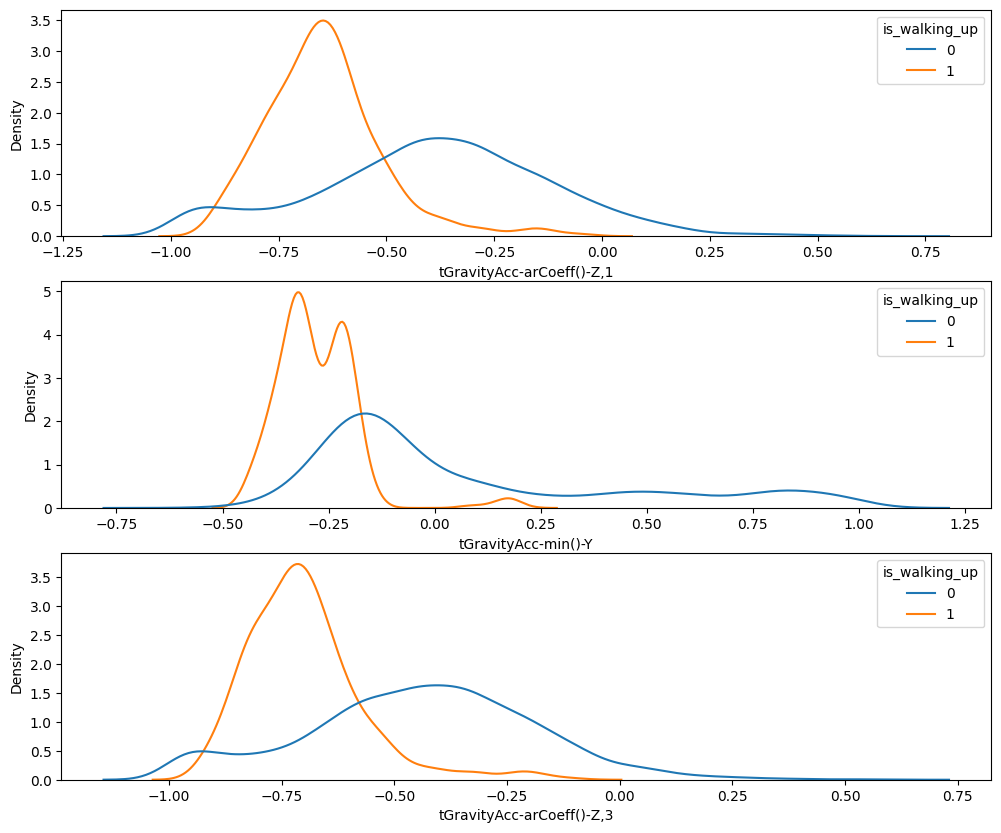

<ipython-input-109-192857254c47>:46: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)


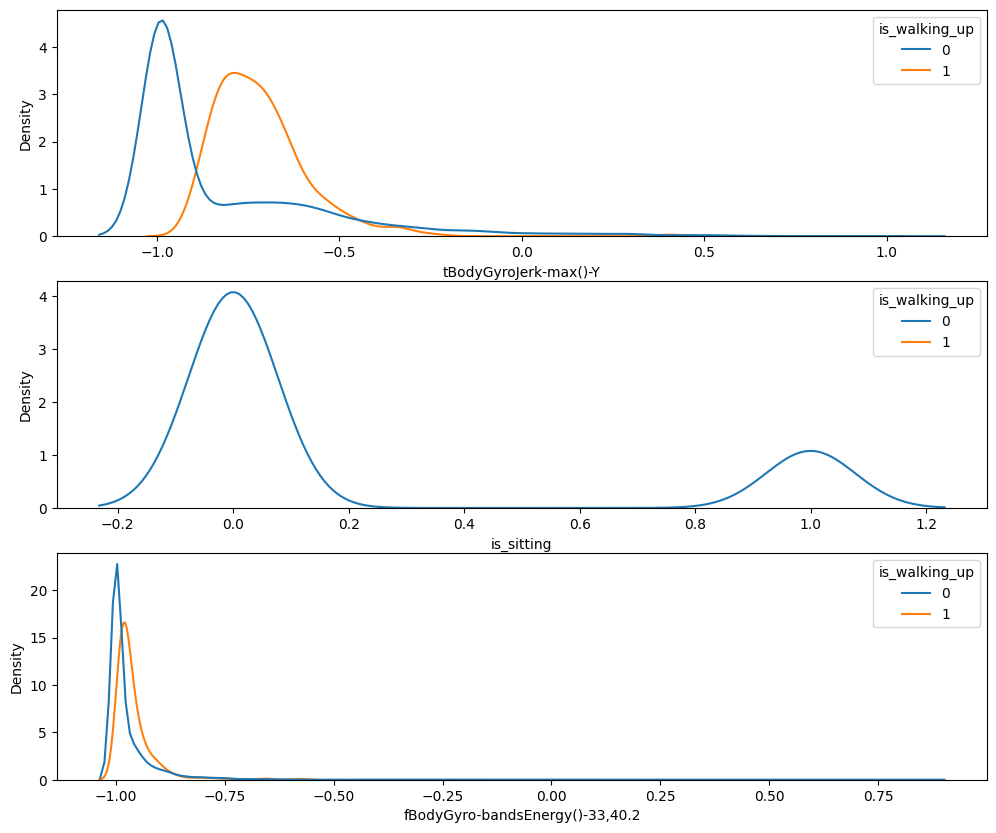

Accuracy: 0.994052676295667
Top 3 Importances: ['tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-min()-Y', 'tGravityAcc-arCoeff()-Z,3']
Bottom 3 Importances: ['tBodyGyroJerk-max()-Y', 'is_sitting', 'fBodyGyro-bandsEnergy()-33,40.2']


'Sensor Importance Summary:'

,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking,importportance_is_walking_up
sensor,,,,,,,
tGravityAcc,0.342681,0.000815,0.388536,0.351293,0.667924,0.148585,0.286562
fBodyAcc,0.081618,0.139411,0.105029,0.053076,0.019993,0.125326,0.182660
fBodyAccJerk,0.101399,0.349652,0.033930,0.042625,0.039014,0.116843,0.107194
fBodyGyro,0.083116,0.019940,0.116872,0.258101,0.015870,0.108080,0.055858
tBodyAcc,0.036624,0.000557,0.062268,0.039709,0.013092,0.047842,0.050723
tBodyAccJerk,0.059880,0.219579,0.017949,0.024935,0.003515,0.072689,0.036338
tBodyAccJerkMag,0.029645,0.080094,0.004494,0.005457,0.000328,0.011377,0.034575
tBodyGyro,0.039541,0.020417,0.063805,0.082390,0.025902,0.014165,0.033461
fBodyBodyAccJerkMag,0.021243,0.049484,0.002802,0.005224,0.000114,0.029366,0.033330


'Sensor + Agg Importance Summary:'

,,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking,importportance_is_walking_up
sensor,agg,,,,,,,
tGravityAcc,arCoeff(),0.071920,0.000017,0.010035,0.006706,0.009111,0.097609,0.161931
fBodyAcc,bandsEnergy(),0.034072,0.029912,0.038339,0.029683,0.007704,0.061120,0.088985
fBodyAccJerk,bandsEnergy(),0.040524,0.110005,0.018662,0.029296,0.016233,0.062275,0.048400
tGravityAcc,min(),0.059618,0.000137,0.101824,0.087645,0.135276,0.007162,0.039194
fBodyAcc,max(),0.004147,0.000020,0.010912,0.002046,0.000977,0.017108,0.034916
...,...,...,...,...,...,...,...,...
tBodyGyroJerkMag,entropy(),0.000247,0.000000,0.000229,0.002216,0.000072,0.003041,0.000057
tGravityAccMag,min(),0.000147,0.000000,0.000275,0.000232,0.000129,0.000152,0.000052
fBodyAccMag,min(),0.000208,0.000000,0.000202,0.000242,0.000000,0.000073,0.000037


,sensor,agg,axis,feature_name,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking,importportance_is_walking_up
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213,0.000009,0.000316,0.000458,0.000143,0.000272,0.000254
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289,0.000017,0.000473,0.000721,0.000069,0.000203,0.000772
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183,0.000034,0.000171,0.000117,0.000034,0.000029,0.000387
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241,0.000009,0.003143,0.003125,0.002322,0.009746,0.009310
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351,0.000000,0.003915,0.000379,0.000711,0.000397,0.000639
...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549,0.000000,0.001799,0.000501,0.000000,0.000183,0.000334
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753,0.000000,0.001643,0.001056,0.000015,0.000058,0.000095
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659,0.000111,0.031404,0.024268,0.126069,0.001377,0.011299
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835,0.000000,0.041812,0.031485,0.025626,0.002458,0.014311


In [115]:
data['is_walking_up'] = data['Activity'].map(lambda x: 1 if x == 'WALKING_UPSTAIRS' else 0)

# 함수 사용 예제
result = analyze_feature_importance(data, 'is_walking_up', ['is_dynamic', 'Activity', 'is_walking_up'], feature1)
print("Accuracy:", result[0])
print('='*200)
print("Top 3 Importances:", result[1])
print('='*200)
print("Bottom 3 Importances:", result[2])
print('='*200)
display("Sensor Importance Summary:", result[3])
print('='*200)
display("Sensor + Agg Importance Summary:", result[4])
print('='*200)
display(result[5])

feature1 = result[5]

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


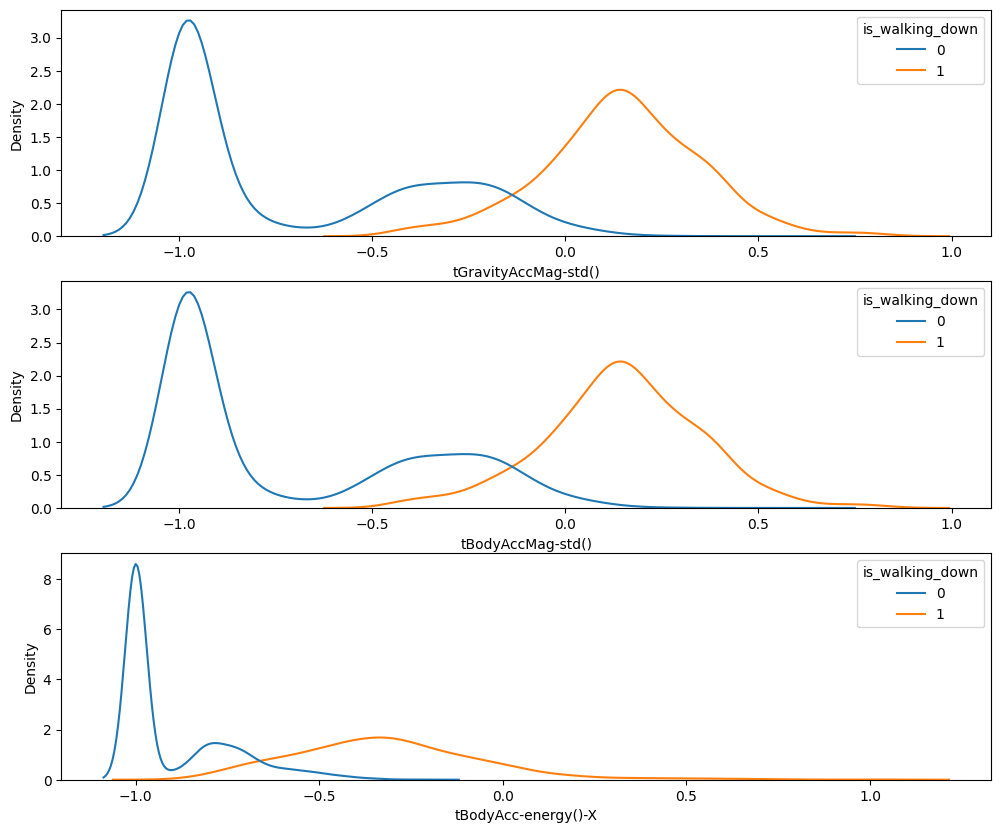

<ipython-input-109-192857254c47>:46: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)
<ipython-input-109-192857254c47>:46: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_train, x=feat, hue=y_train, common_norm=False)


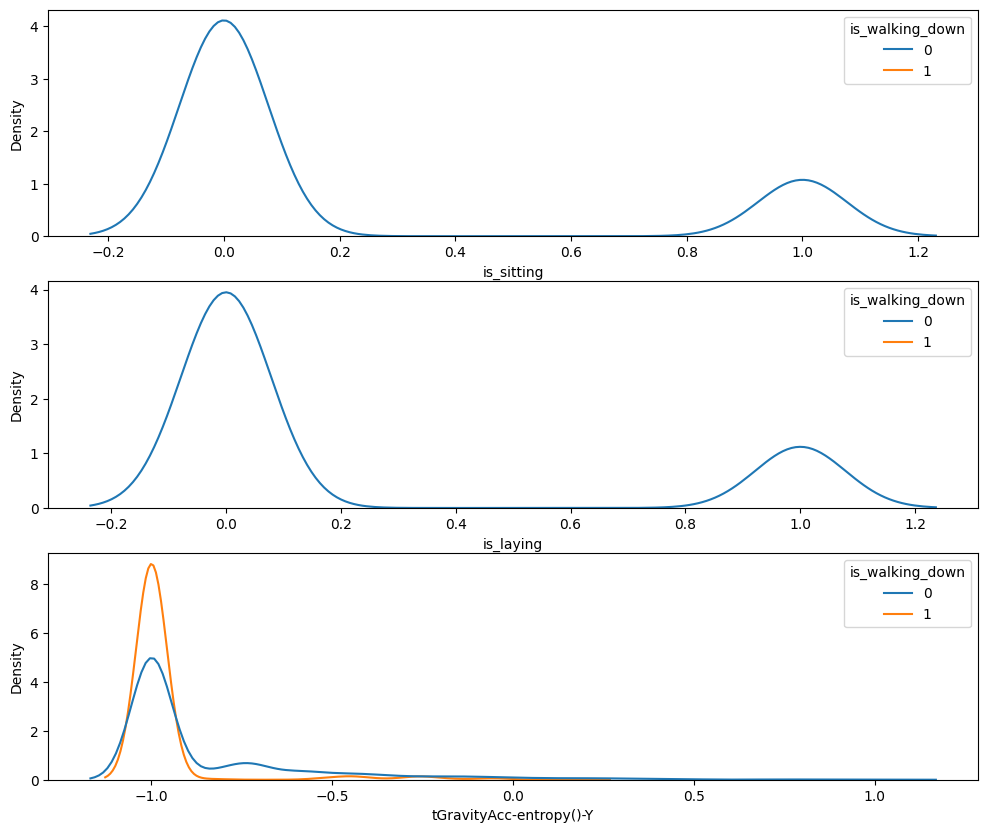

Accuracy: 0.9906542056074766
Top 3 Importances: ['tGravityAccMag-std()', 'tBodyAccMag-std()', 'tBodyAcc-energy()-X']
Bottom 3 Importances: ['is_sitting', 'is_laying', 'tGravityAcc-entropy()-Y']


'Sensor Importance Summary:'

,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking,importportance_is_walking_up,importportance_is_walking_down
sensor,,,,,,,,
fBodyAccMag,0.043906,0.009906,0.026095,0.003776,0.000302,0.085798,0.022949,0.165033
fBodyAcc,0.081618,0.139411,0.105029,0.053076,0.019993,0.125326,0.182660,0.145483
tBodyAcc,0.036624,0.000557,0.062268,0.039709,0.013092,0.047842,0.050723,0.131174
tGravityAccMag,0.022778,0.000000,0.028756,0.003132,0.001308,0.062501,0.019113,0.111979
tBodyAccMag,0.027031,0.000000,0.019901,0.003329,0.000609,0.084271,0.018605,0.108565
fBodyAccJerk,0.101399,0.349652,0.033930,0.042625,0.039014,0.116843,0.107194,0.081557
tBodyAccJerk,0.059880,0.219579,0.017949,0.024935,0.003515,0.072689,0.036338,0.054972
tGravityAcc,0.342681,0.000815,0.388536,0.351293,0.667924,0.148585,0.286562,0.046008
fBodyGyro,0.083116,0.019940,0.116872,0.258101,0.015870,0.108080,0.055858,0.041275


'Sensor + Agg Importance Summary:'

,,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking,importportance_is_walking_up,importportance_is_walking_down
sensor,agg,,,,,,,,
fBodyAcc,bandsEnergy(),0.034072,0.029912,0.038339,0.029683,0.007704,0.061120,0.088985,0.067574
fBodyAccJerk,bandsEnergy(),0.040524,0.110005,0.018662,0.029296,0.016233,0.062275,0.048400,0.044662
tGravityAccMag,std(),0.007326,0.000000,0.006273,0.000264,0.000000,0.021806,0.003902,0.040701
tBodyAccMag,std(),0.009069,0.000000,0.006180,0.000213,0.000000,0.016443,0.001580,0.038074
tBodyAcc,energy(),0.004580,0.000009,0.013054,0.003967,0.001534,0.003923,0.002758,0.037261
...,...,...,...,...,...,...,...,...,...
fBodyBodyGyroMag,std(),0.000144,0.000000,0.000200,0.000619,0.000011,0.000111,0.000093,0.000062
angle,tBodyAccMean,0.000144,0.000000,0.000145,0.000236,0.000000,0.000074,0.000155,0.000058
fBodyBodyAccJerkMag,maxInds,0.000270,0.000004,0.000217,0.000073,0.000021,0.000326,0.000426,0.000049


,sensor,agg,axis,feature_name,importance_mission1,importance_mission2,importportance_is_standing,importportance_is_sitting,importportance_is_laying,importportance_is_walking,importportance_is_walking_up,importportance_is_walking_down
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000213,0.000009,0.000316,0.000458,0.000143,0.000272,0.000254,0.000350
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000289,0.000017,0.000473,0.000721,0.000069,0.000203,0.000772,0.000139
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000183,0.000034,0.000171,0.000117,0.000034,0.000029,0.000387,0.000388
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004241,0.000009,0.003143,0.003125,0.002322,0.009746,0.009310,0.029355
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000351,0.000000,0.003915,0.000379,0.000711,0.000397,0.000639,0.000447
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000549,0.000000,0.001799,0.000501,0.000000,0.000183,0.000334,0.000304
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000753,0.000000,0.001643,0.001056,0.000015,0.000058,0.000095,0.000096
558,angle,X,gravityMean,"angle(X,gravityMean)",0.024659,0.000111,0.031404,0.024268,0.126069,0.001377,0.011299,0.001533
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.026835,0.000000,0.041812,0.031485,0.025626,0.002458,0.014311,0.004965


from matplotlib import pyplot as plt
feature1['importance_mission1'].plot(kind='hist', bins=20, title='importance_mission1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1['importance_mission2'].plot(kind='hist', bins=20, title='importance_mission2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1['importportance_is_standing'].plot(kind='hist', bins=20, title='importportance_is_standing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1['importportance_is_sitting'].plot(kind='hist', bins=20, title='importportance_is_sitting')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1.plot(kind='scatter', x='importance_mission1', y='importance_mission2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1.plot(kind='scatter', x='importance_mission2', y='importportance_is_standing', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1.plot(kind='scatter', x='importportance_is_standing', y='importportance_is_sitting', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1.plot(kind='scatter', x='importportance_is_sitting', y='importportance_is_laying', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
feature1['importance_mission1'].plot(kind='line', figsize=(8, 4), title='importance_mission1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
feature1['importance_mission2'].plot(kind='line', figsize=(8, 4), title='importance_mission2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
feature1['importportance_is_standing'].plot(kind='line', figsize=(8, 4), title='importportance_is_standing')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
feature1['importportance_is_sitting'].plot(kind='line', figsize=(8, 4), title='importportance_is_sitting')
plt.gca().spines[['top', 'right']].set_visible(False)

In [116]:
data['is_walking_down'] = data['Activity'].map(lambda x: 1 if x == 'WALKING_DOWNSTAIRS' else 0)

# 함수 사용 예제
result = analyze_feature_importance(data, 'is_walking_down', ['is_dynamic', 'Activity', 'is_walking_down'], feature1)
print("Accuracy:", result[0])
print('='*200)
print("Top 3 Importances:", result[1])
print('='*200)
print("Bottom 3 Importances:", result[2])
print('='*200)
display("Sensor Importance Summary:", result[3])
print('='*200)
display("Sensor + Agg Importance Summary:", result[4])
print('='*200)
display(result[5])

feature1 = result[5]

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [ ]:
#위에서 이미 다 합침

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [117]:
import joblib

# DataFrame을 .pkl 파일로 저장
joblib.dump(feature1, '/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

['/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl']